# Setup

In [1]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="3"

# Generate Data

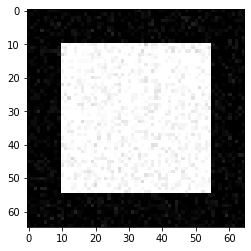

In [2]:
input = np.zeros((65, 65))
input[2, 5] = 0.4
input[12, 17] = 0.7

a,b= np.meshgrid(np.linspace(-1, 1, 65), np.linspace(-1, 1, 65))
Img = np.array(np.logical_and(np.abs(a) < 0.7, np.abs(b) < 0.7),dtype='float32') 

IMG_T=torch.FloatTensor(Img)
IMG_T.shape
IMG_T2 = torch.unsqueeze(IMG_T, dim=0)
IMG_T2.shape
noisyImg = np.clip(Img + np.random.normal(scale=0.05, size=IMG_T2.shape), 0, 1).astype(np.float32) # adding noise from normal distribution
noisyImg_T=torch.FloatTensor(noisyImg)
noisyImg_T.shape
plt.imshow(noisyImg_T[0], cmap='gray')
clean=IMG_T2.unsqueeze(0)
noisy=noisyImg_T.unsqueeze(0)


In [3]:
clean.shape

torch.Size([1, 1, 65, 65])

In [4]:
noisy.shape

torch.Size([1, 1, 65, 65])

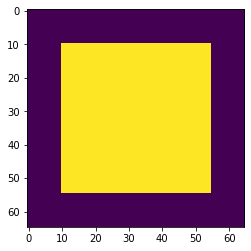

In [5]:
plt.imshow(clean[0][0])

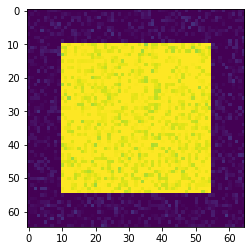

In [6]:
plt.imshow(noisy[0][0])

In [7]:
torch.max(noisy)

tensor(1.)

In [8]:
class Anet(nn.Module):
    def __init__(self, channel=8):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(65,1),padding=(32,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,65),padding=(0,32), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =self.conv1(x)
        #x1 =F.relu(self.conv1(x))
        #out =F.relu(self.conv2(x1))
        out = self.conv2(x1)
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 65, 65)
A_net(x).shape

torch.Size([1, 1, 65, 65])

In [9]:
from zmq import device
## reshape the tensors to a matrix

## inner dim =2
[8, 1, 65, 1]
[1,8, 1, 65]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV

## getting singular values

def my_singular(U, V):
  UV=my_outer(U, V)
  return np.array(torch.linalg.svdvals(UV).to('cpu').detach())
   
  

 #def my_svd(U,V):
    #UV=my_outer(U, V)
    #A,S,B= np.array(torch.svd_lowrank(UV, q=8, niter=2, M=None).to('cpu').detach())
    #return A,S,B



def Nuc_norm(U,V):
    sigma_vec= my_singular(U, V)
    return np.sum(sigma_vec)


In [10]:
def plot_epoch(recon_np,noisyImg1, Img):
  #if i % 50 == 0:
    fig = plt.figure(figsize=(7, 7))
    rows = 2
    columns = 2
    plt.subplot(rows, columns, 1)
    #recon_np = recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy()
    plt.imshow(recon_np, cmap='gray')
    plt.axis('off')
    plt.title("recon")
    plt.subplot(rows, columns, 2)
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.title("Img")
    plt.subplot(rows, columns, 3)
    plt.imshow(noisyImg1, cmap='gray')
    plt.axis('off')
    plt.title("Img+Noise")
    plt.show()
    plt.show()

> ### Training Function








In [11]:
def recon(noisy, clean, alpha=0., iterations=100000, lr=1.e-2, gpu=True):
  import time

  cuda = torch.device('cuda') 

  A_net = Anet()
  x = torch.randn(1, 1, 65, 65)

  if gpu:
    A_net = A_net.to(cuda)
    x = x.to(cuda)
    noisy = noisy.to(cuda)
    clean = clean.to(cuda)

    #U=U.to(cuda)
    #V=V.to(cuda)
  
  optimizer = optim.SGD(A_net.parameters(), lr=lr)

  Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = [],[], [], [], [],[], [], [], [], [],[]

  start = time.time()
  for i in tqdm(range(iterations)):

    recon = A_net(x)
    
    l2_norm = sum(p.pow(2.0).sum() for p in A_net.parameters()) #L2 norm of weights (p**2)
    U, V=[ p for p in A_net.parameters()]  ## get the kernels

    loss_recon = mse(recon, noisy)
    Loss_Rec.append(loss_recon.item())
    
    loss_regu = alpha * l2_norm
    Loss_Reg.append(loss_regu.item())

    loss = loss_recon + loss_regu
    Loss.append(loss.item())

    error = mse(recon, clean)
    Error.append(error.item())
    
    #SVD.append(my_svd(U,V))
    S_values.append(my_singular(U, V))
    UV_outer.append(my_outer(U, V))
    Recons.append(recon)
    U_kernel.append(U)
    V_kernel.append(V)
    
    norm2.append(l2_norm)
    Nuc.append(Nuc_norm(U,V))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    #if i % 10000 == 0:
      #plot_epoch(recon[0].squeeze(0).permute(1, 0).to('cpu').detach().numpy(), noisyImg_T[0], Img)
  end = time.time()
  print(f"ending time in: {((end-start)/60):.3f} mins")
  

  return Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 

# Reco for different Alpha

In [12]:
from numpy.ma.core import outer
Loss_Rec, Loss_Reg, Loss, Error, Sigma, OutP, Rec, kerU, kerV, Norm1, Norm2 = [], [], [], [], [],[], [], [], [], [],[]

#Adapot alpha here!!!!
Alpha = np.linspace(0,0.01,3)

for alpha in Alpha:

  print(alpha)
  # lr 1.e-1 is too large ?
  # ->need more iterations ~ maybe 100000 are too many? 
  loss_rec, loss_reg, loss, error, s, outer, recs, u_ker, v_ker,nuc_norm, norm_2 = recon(noisy, clean, gpu=True , alpha=alpha, iterations=100000)

  Loss_Rec.append(loss_rec)
  Loss_Reg.append(loss_reg)
  Loss.append(loss)
  Error.append(error)
  Sigma.append(s)
  OutP.append(outer)
  Rec.append(recs)
  kerU.append(u_ker)
  kerV.append(v_ker)
  Norm1.append(nuc_norm)
  Norm2.append(norm_2)  


Loss_Rec2=np.array(Loss_Rec)
Loss_Reg2=np.array(Loss_Reg)
Loss2=np.array(Loss)
Error2=np.array(Error)
Sigma_arr2=np.array(Sigma)
OutP_arr2= np.array(OutP)
Rec_arr2= np.array(Rec)
kerU_arr2= np.array(kerU)
kerV_arr2= np.array(kerV)
Norm1_arr2= np.array(Norm1)
Norm2_arr2= np.array(Norm2)

0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 11.818 mins
0.005


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 12.227 mins
0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 31.75 GiB total capacity; 6.63 GiB already allocated; 4.00 MiB free; 6.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import sys
#sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [62]:
#save files
np.save("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec2) 
np.save("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg2)
np.save("/home/sbazoobandi/data/Loss.npy",Loss2)
np.save("/home/sbazoobandi/data/Error.npy", Error2)
np.save("/home/sbazoobandi/data/Alpha.npy", Alpha)
np.save("/home/sbazoobandi/data/Sigma.npy", Sigma_arr2)
np.save("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr2)
np.save("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr2)
np.save("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr2)
np.save("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr2)
np.save("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr2)

# Load files and Plotting

In [ ]:
Loss_Rec=np.load("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec2) 
Loss_Reg=np.load("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg2)
Loss=np.load("/home/sbazoobandi/data/Loss.npy",Loss2)
Error=np.load("/home/sbazoobandi/data/Error.npy", Error2)
Alpha=np.load("/home/sbazoobandi/data/Alpha.npy", Alpha)
Sigma_arr=np.load("/home/sbazoobandi/data/Sigma.npy", Sigma_arr2)
OutP_arr=np.load("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr2)
Rec_arr=np.load("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr2)
kerU_arr=np.load("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr2)
kerV_arr=np.load("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr2)
Norm1_arr=np.load("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr2)

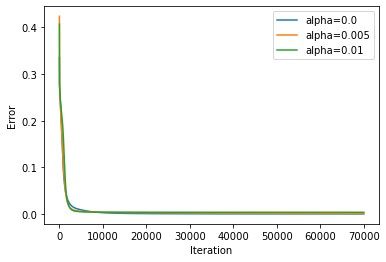

In [64]:
for i in range(Alpha.shape[0]):
  plt.plot(Error2[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()

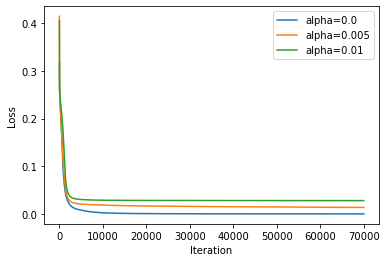

In [65]:
for i in range(Alpha.shape[0]):
  plt.plot(Loss2[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()
plt.show()


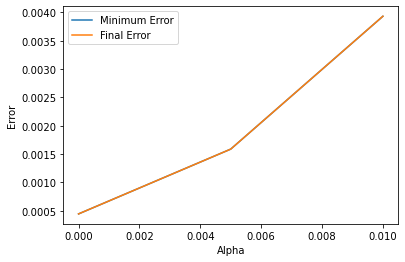

In [66]:
plt.plot(Alpha, np.min(Error2, axis=1), label="Minimum Error")
plt.plot(Alpha, Error2[:,-1], label="Final Error")

plt.xlabel("Alpha")
plt.ylabel("Error")

plt.legend()
plt.show()


  0%|          | 0/100000 [00:00<?, ?it/s]

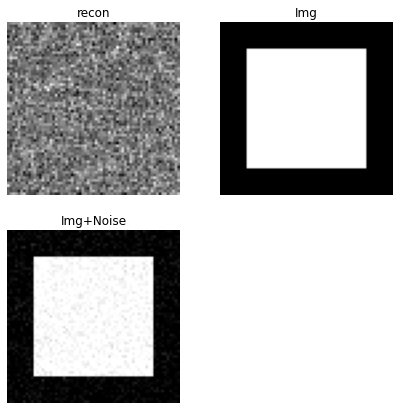

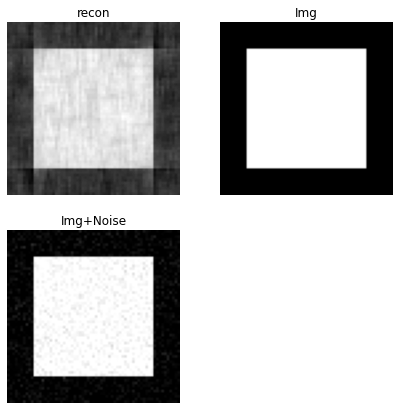

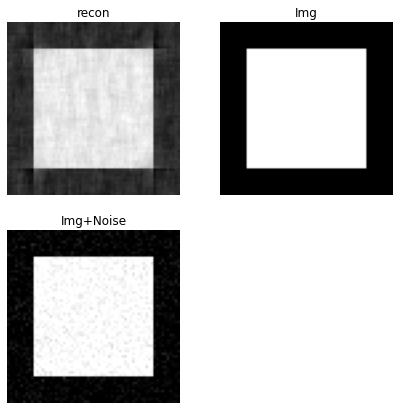

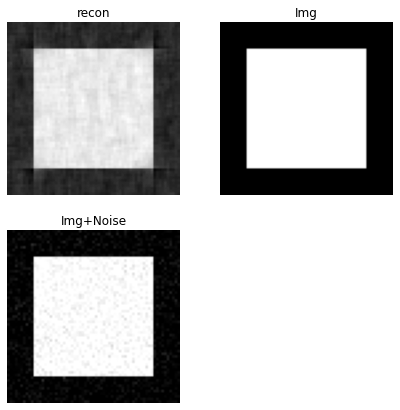

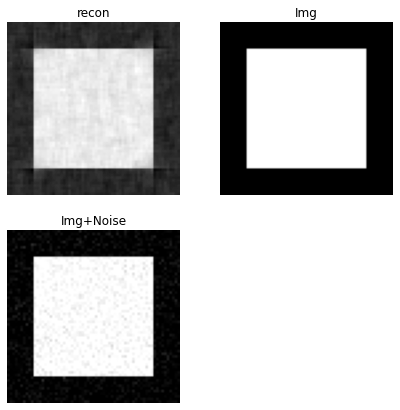

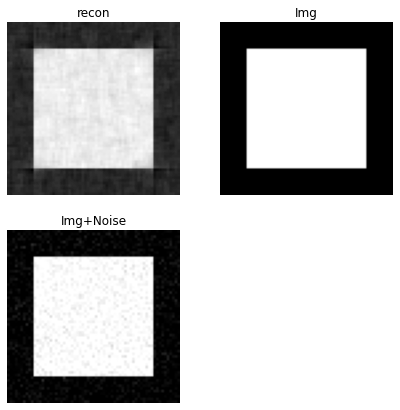

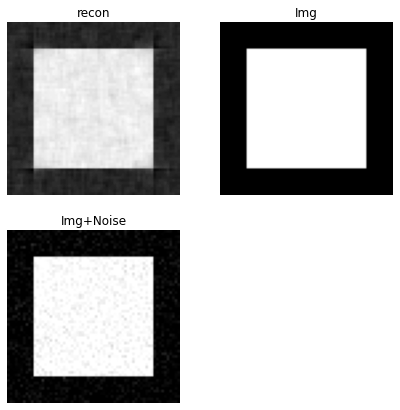

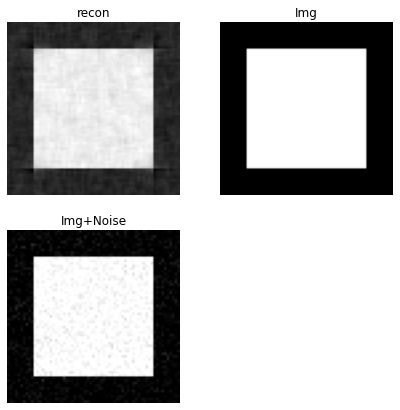

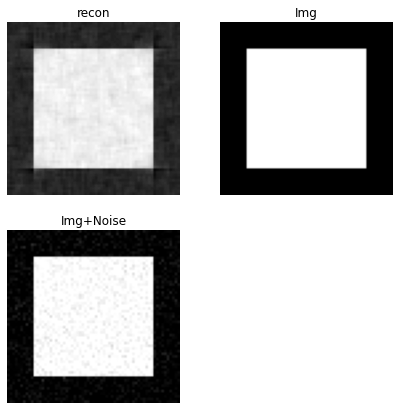

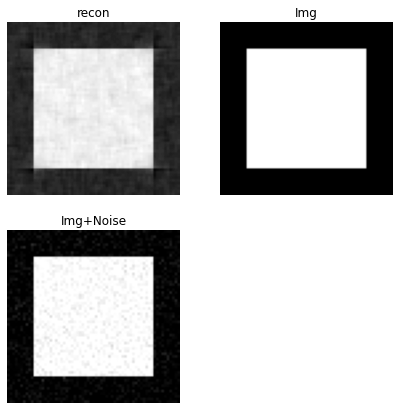

ending time in: 11.562 mins


In [14]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.001, iterations=100000) 

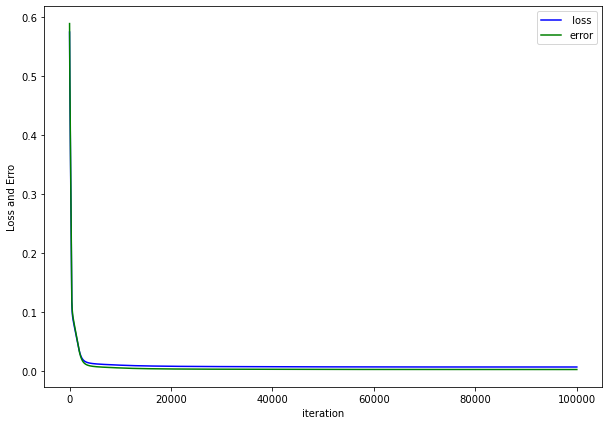

In [15]:
plt.figure(figsize=(10, 7)) #90 itr.
plt.plot(Loss, color='blue', label=' loss')
plt.plot(Error, color='green', label='error')
#plt.title('alpha=0') ###### early stopping
#plt.title('alpha=0.001')
plt.xlabel('iteration')
plt.ylabel('Loss and Erro')
plt.legend()
#plt.savefig('/content/drive/My Drive/psnr.png')
plt.show()

Text(0.5, 1.0, 'Plot of singular values')

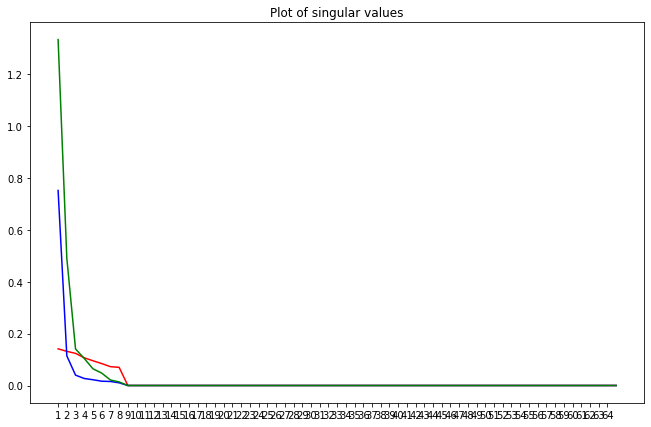

In [16]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "red" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "blue" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "green" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'singular values')

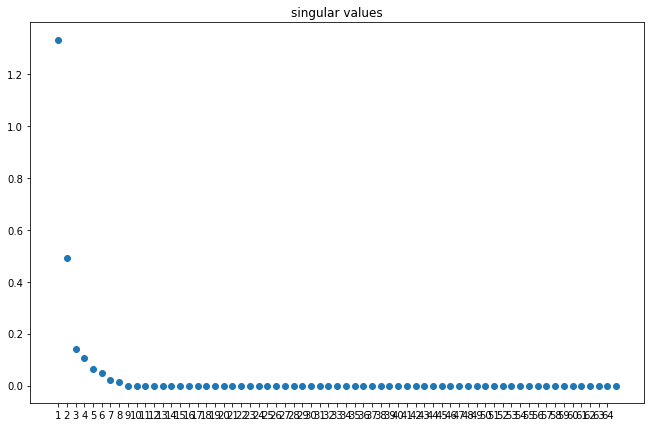

In [17]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" )
plt.xticks(np.arange(1, len(S_values[0] + 1)))
#plt.yscale("log")
plt.title("singular values")

Text(0.5, 1.0, 'singular values')

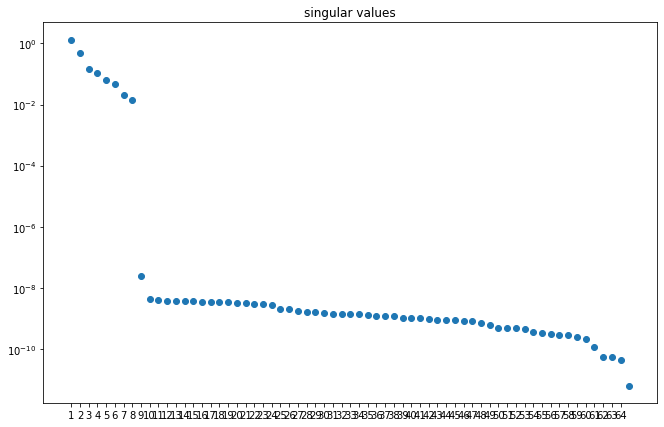

In [19]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" ) ####100,000 itr.!!!!
plt.xticks(np.arange(1, len(S_values[0] + 1)))
plt.yscale("log")
plt.title("singular values")

In [20]:
kernel=UV_outer[99000].cpu().detach()

In [21]:
kernel

tensor([[0.0176, 0.0146, 0.0131,  ..., 0.0124, 0.0148, 0.0157],
        [0.0173, 0.0140, 0.0123,  ..., 0.0127, 0.0147, 0.0154],
        [0.0185, 0.0153, 0.0134,  ..., 0.0139, 0.0152, 0.0163],
        ...,
        [0.0288, 0.0245, 0.0231,  ..., 0.0209, 0.0252, 0.0265],
        [0.0209, 0.0171, 0.0158,  ..., 0.0138, 0.0174, 0.0187],
        [0.0192, 0.0159, 0.0147,  ..., 0.0117, 0.0151, 0.0168]])

In [23]:
_,Sigma,_=torch.svd_lowrank(kernel, q=8, niter=2, M=None)

Text(0.5, 1.0, 'singular values')

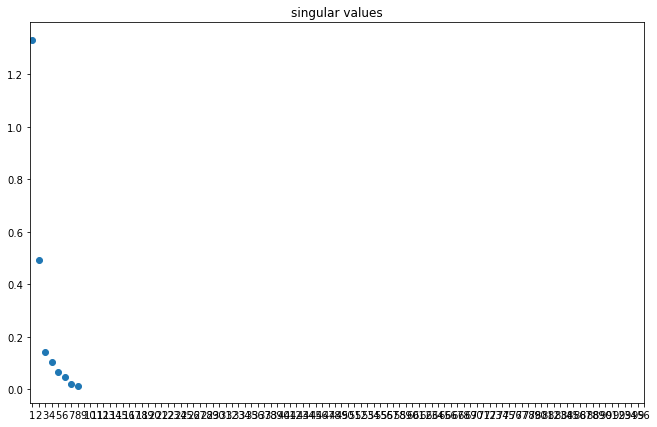

In [24]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(Sigma) + 1),Sigma, "o" )
plt.xticks(np.arange(1, 97))
#plt.yscale("log")
plt.title("singular values")

In [25]:
rec_f=Recons[99000].cpu().detach()

In [26]:
rec_f.shape

torch.Size([1, 1, 65, 65])

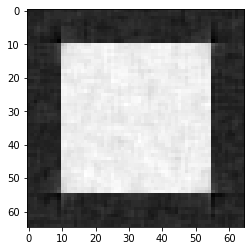

In [27]:
plt.imshow(rec_f[0][0], cmap="gray")

In [28]:
U, s, V = np.linalg.svd(rec_f[0][0], full_matrices=False)

Text(0.5, 1.0, 'singular values')

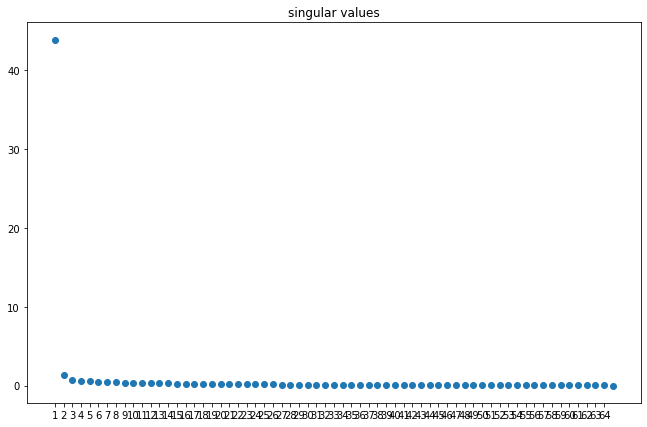

In [29]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 65))
#plt.yscale("log")
plt.title("singular values")

In [30]:
UV_outer

[tensor([[-0.0044, -0.0057,  0.0121,  ..., -0.0072, -0.0036,  0.0008],
         [ 0.0040, -0.0053, -0.0128,  ...,  0.0081, -0.0018,  0.0056],
         [ 0.0004, -0.0015, -0.0086,  ...,  0.0077,  0.0019,  0.0064],
         ...,
         [-0.0007, -0.0033, -0.0122,  ...,  0.0107, -0.0047,  0.0043],
         [-0.0081, -0.0067,  0.0022,  ..., -0.0009, -0.0085, -0.0007],
         [ 0.0055, -0.0131, -0.0110,  ...,  0.0015, -0.0098, -0.0022]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[-0.0043, -0.0056,  0.0120,  ..., -0.0071, -0.0035,  0.0008],
         [ 0.0040, -0.0052, -0.0127,  ...,  0.0081, -0.0018,  0.0056],
         [ 0.0004, -0.0015, -0.0085,  ...,  0.0077,  0.0019,  0.0063],
         ...,
         [-0.0008, -0.0033, -0.0121,  ...,  0.0106, -0.0047,  0.0043],
         [-0.0080, -0.0066,  0.0022,  ..., -0.0008, -0.0084, -0.0007],
         [ 0.0055, -0.0130, -0.0109,  ...,  0.0015, -0.0097, -0.0022]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[-0.0042,

In [32]:
UV_kernel=UV_outer[99000].cpu().detach()

In [33]:
UV_kernel.shape

torch.Size([65, 65])

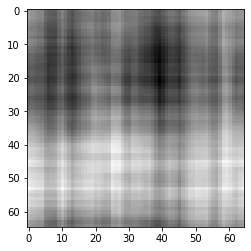

In [34]:
plt.imshow(UV_kernel, cmap="gray")

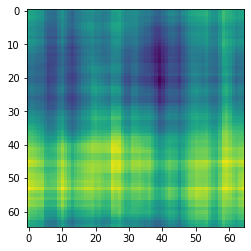

In [35]:
plt.imshow(UV_kernel)

In [36]:
U, s, V = np.linalg.svd(UV_kernel, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

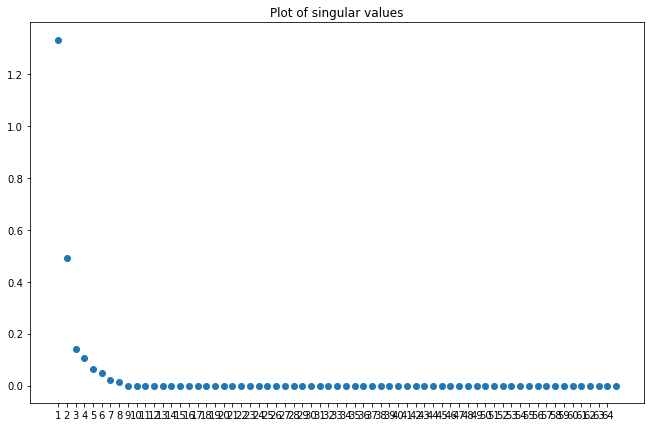

In [37]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 65))
#plt.yscale("log")
plt.title("Plot of singular values")

In [38]:
UV_kernel=np.array(UV_kernel)

In [39]:
UV_kernel.shape

(65, 65)

In [40]:
UV_kernel_transformed= np.fft.fft2(UV_kernel, axes=[0,1])

In [41]:
U, s, V = np.linalg.svd(UV_kernel_transformed, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

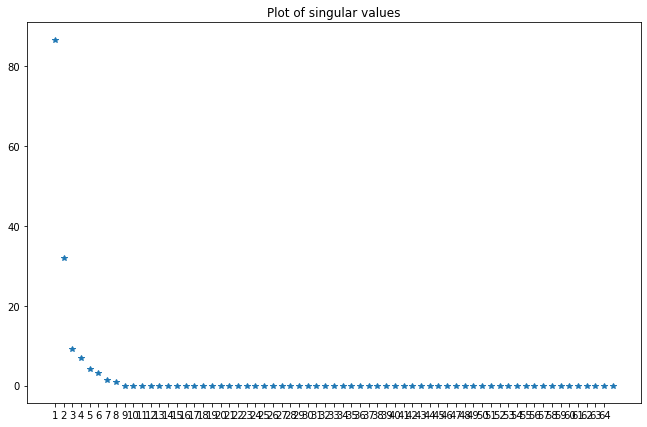

In [42]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "*" )
plt.xticks(np.arange(1, 65))
#plt.yscale("log")
plt.title("Plot of singular values")

In [43]:
U, s, V = np.linalg.svd(noisyImg, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

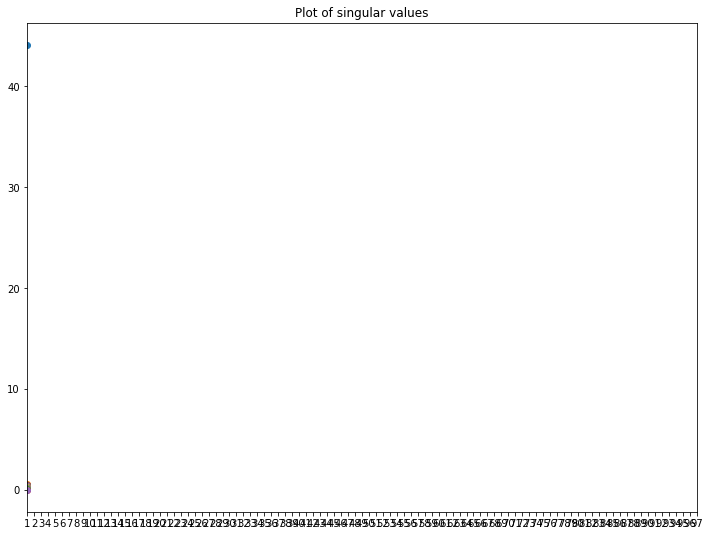

In [44]:
plt.figure(figsize= (12,9))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [45]:
Nuc

[0.89373225,
 0.8864341,
 0.8792517,
 0.8721806,
 0.8652247,
 0.8583784,
 0.85163856,
 0.84500414,
 0.8384745,
 0.8320463,
 0.82572013,
 0.81949294,
 0.813362,
 0.80732745,
 0.8013873,
 0.7955405,
 0.7897849,
 0.78411907,
 0.77854145,
 0.77305144,
 0.76764756,
 0.7623271,
 0.7570909,
 0.75193715,
 0.74686456,
 0.74187213,
 0.7369583,
 0.73212194,
 0.7273625,
 0.72267807,
 0.7180689,
 0.71353114,
 0.7090684,
 0.70467544,
 0.7003553,
 0.6961024,
 0.69191957,
 0.68780506,
 0.68375707,
 0.6797737,
 0.67585546,
 0.67200303,
 0.66821295,
 0.6644869,
 0.66082084,
 0.6572155,
 0.6536728,
 0.65018725,
 0.6467612,
 0.64339256,
 0.6400809,
 0.6368253,
 0.6336277,
 0.6304826,
 0.6273923,
 0.62435555,
 0.6213714,
 0.6184392,
 0.6155589,
 0.61272895,
 0.60994947,
 0.6072185,
 0.6045365,
 0.601904,
 0.5993178,
 0.5967778,
 0.5942872,
 0.5918399,
 0.5894376,
 0.5870806,
 0.58476746,
 0.5824976,
 0.58027095,
 0.5780864,
 0.57594347,
 0.57384205,
 0.571781,
 0.56976026,
 0.56777996,
 0.56583774,
 0.5639

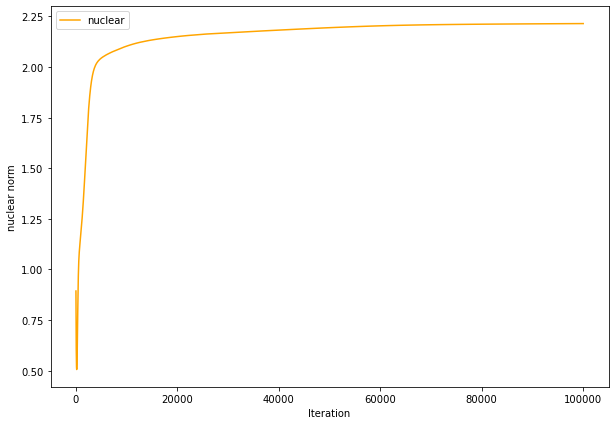

In [46]:
## nuclear norm
plt.figure(figsize=(10, 7))
plt.plot(Nuc, color='orange', label='nuclear')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('nuclear norm')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()

In [47]:
norm2

[tensor(3.0222, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(3.0134, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(3.0048, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9963, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9881, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9800, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9721, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9643, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9567, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9492, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9419, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9348, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9278, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9209, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9141, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9075, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.9010, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.8947

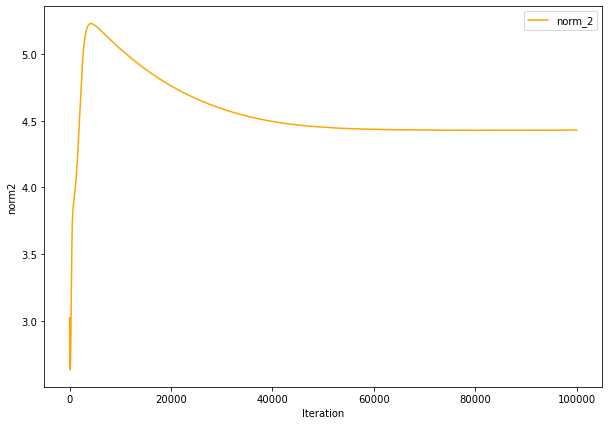

In [48]:
## 2 norm
plt.figure(figsize=(10, 7))
plt.plot(norm2, color='orange', label='norm_2')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('norm2')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()